In [1]:
# Libraries and utilities

# RENINDER: FARE FIT.TRANSFORM SOLO SU TRAINING E DOPO SUL TEST SOLO .TRANSFORM
# REMINDER: NORMALIZZARE PRIMA DI FARE TUTTO IL PREPROCESSING 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler,MinMaxScaler,StandardScaler, OneHotEncoder
from sklearn import preprocessing

from sklearn.model_selection import StratifiedKFold,RepeatedStratifiedKFold, RandomizedSearchCV,GridSearchCV, RepeatedKFold, train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)

from scikitplot.metrics import plot_roc

from collections import Counter
from imblearn.datasets import make_imbalance

from sklearn.metrics import roc_curve, auc, roc_auc_score

In [2]:
df_train=pd.read_csv("../Dataset_prepared/Prepared_train.csv")
df_test=pd.read_csv("../Dataset_prepared/Prepared_test.csv")

df_train.drop('actor',axis=1,inplace=True)
df_train.drop('filename',axis=1,inplace=True)

df_test.drop('actor',axis=1,inplace=True)
df_test.drop('filename',axis=1,inplace=True)

In [3]:

#creating instance of one-hot-encoder
encoder = OneHotEncoder()
#perform one-hot encoding on 'emotion' column 
encoder_df = pd.DataFrame(encoder.fit_transform(df_train[['emotion']]).toarray())
encoder_df_test = pd.DataFrame(encoder.fit_transform(df_test[['emotion']]).toarray())
#merge one-hot encoded columns back with original DataFrame
df_train = df_train.join(encoder_df)
df_test = df_test.join(encoder_df_test)
#drop 'emotion' column
df_train.drop('emotion', axis=1, inplace=True)
df_test.drop('emotion', axis=1, inplace=True)
#rename 0=Angry column
df_train.rename(columns = {0:'IsAngry?'}, inplace = True)
df_test.rename(columns = {0:'IsAngry?'}, inplace = True)
#drop other emotion columns
df_train.drop([1,2,3,4,5,6,7],axis=1,inplace=True)
df_test.drop([1,2,3,4,5,6,7],axis=1,inplace=True)
#transform IsAngry? from float to integer
df_train['IsAngry?'] = df_train['IsAngry?'].astype(int)
df_test["IsAngry?"] = df_test['IsAngry?'].astype(int)


In [4]:
df_train.head()

,vocal_channel,emotional_intensity,statement,repetition,sex,mean,q25,q50,q75,kur,...,stft_sum_w4,stft_q01_w4,stft_q05_w4,stft_q25_w4,stft_q50_w4,stft_q75_w4,stft_q95_w4,stft_kur_w4,stft_skew_w4,IsAngry?
0,speech,normal,Kids are talking by the door,1st,M,9.150000e-07,-0.000031,0.0,0.0,15.028520,...,740.409892,0.000000,0.566462,0.709962,0.799141,0.896606,1.0,6.742190,-1.706215,0
1,speech,normal,Kids are talking by the door,2nd,M,7.137790e-07,-0.000031,0.0,0.0,16.488415,...,705.975006,0.368623,0.472736,0.623183,0.744908,0.874713,1.0,-0.700420,-0.201495,0
2,speech,normal,Dogs are sitting by the door,1st,M,9.554485e-07,0.000000,0.0,0.0,17.035218,...,694.365924,0.000000,0.417919,0.643636,0.774253,0.899156,1.0,1.688986,-1.024773,0
3,speech,normal,Dogs are sitting by the door,2nd,M,9.176213e-07,-0.000031,0.0,0.0,21.824521,...,663.205667,0.306280,0.399641,0.606910,0.755213,0.886474,1.0,-0.594111,-0.412871,0
4,speech,normal,Kids are talking by the door,1st,M,8.108948e-07,-0.000031,0.0,0.0,13.236022,...,741.412796,0.248765,0.428202,0.634815,0.759914,0.878014,1.0,0.126535,-0.620782,0


In [5]:
df_test.head()

,vocal_channel,emotional_intensity,statement,repetition,sex,mean,q25,q50,q75,kur,...,stft_sum_w4,stft_q01_w4,stft_q05_w4,stft_q25_w4,stft_q50_w4,stft_q75_w4,stft_q95_w4,stft_kur_w4,stft_skew_w4,IsAngry?
0,speech,normal,Kids are talking by the door,1st,M,2.940224e-06,-0.000092,0.0,0.000153,11.392131,...,727.157574,0.306697,0.466157,0.645931,0.789123,0.908316,1.0,-0.260279,-0.566556,0
1,speech,normal,Kids are talking by the door,2nd,M,7.733752e-07,-0.000122,0.0,0.000153,13.621589,...,637.658102,0.170786,0.279347,0.557524,0.733053,0.866973,1.0,-0.428900,-0.587210,0
2,speech,normal,Dogs are sitting by the door,1st,M,-3.741909e-06,-0.000061,0.0,0.000092,7.678162,...,672.592436,0.023285,0.305395,0.577750,0.741576,0.889984,1.0,0.626916,-0.883317,0
3,speech,normal,Dogs are sitting by the door,2nd,M,-5.069646e-07,-0.000092,0.0,0.000122,14.511231,...,704.158385,0.368081,0.434591,0.620144,0.776419,0.904668,1.0,-0.825144,-0.383701,0
4,speech,normal,Kids are talking by the door,1st,M,8.640319e-07,-0.000061,0.0,0.000122,8.944732,...,780.167518,0.298851,0.393112,0.623309,0.772964,0.907035,1.0,-0.536669,-0.547354,0


In [6]:
# Percentage of Angry records in train and test datasets
train_values=df_train.values
train_target=np.array(df_train["IsAngry?"])
test_values=df_test.values
test_target=np.array(df_test["IsAngry?"])

In [7]:
print(f"Valori ed etichette nel train:{len(train_values), len(train_target)}")
print(f"Valori ed etichette nel test:{len(test_values), len(test_target)}")

Valori ed etichette nel train:(1828, 1828)
Valori ed etichette nel test:(624, 624)


In [8]:
np.unique(train_target, return_counts=True), np.unique(test_target, return_counts=True)


((array([0, 1]), array([1548,  280], dtype=int64)),
 (array([0, 1]), array([528,  96], dtype=int64)))

In [9]:
print(f"Train !Angry: {1548/1828}, Train Angry: {280/1828}")
print(f"Test  !Angry: {528/624}, Train Angry: {96/624}")

Train !Angry: 0.8468271334792122, Train Angry: 0.15317286652078774
Test  !Angry: 0.8461538461538461, Train Angry: 0.15384615384615385


In [10]:
# Label encoding categorical columns for train and test
le=preprocessing.LabelEncoder()
c = df_train.select_dtypes(include=['object']).columns.tolist()
for i in c:
    df_train[i]=le.fit_transform(df_train[i])

for i in c:
    df_test[i]=le.fit_transform(df_test[i])


#Normalization numerical pure feature for training and test
scaler = StandardScaler()
numeric_features = [n for n in df_train.columns if n!="IsAngry?" and n!= "vocal_channel" and n!= "emotional_intensity" and n!= "statement" and n!= "repetition" and n!= "sex"]
scaled_features = scaler.fit_transform(df_train[numeric_features])
df_train[numeric_features] = scaled_features


scaled_features_test = scaler.transform(df_test[numeric_features])
df_test[numeric_features] = scaled_features_test

In [11]:
df_train.head()

,vocal_channel,emotional_intensity,statement,repetition,sex,mean,q25,q50,q75,kur,...,stft_sum_w4,stft_q01_w4,stft_q05_w4,stft_q25_w4,stft_q50_w4,stft_q75_w4,stft_q95_w4,stft_kur_w4,stft_skew_w4,IsAngry?
0,1,0,1,0,1,0.018034,0.603864,-0.063106,-0.7693,0.553248,...,0.161158,-0.925138,2.167997,1.515260,1.079945,0.690192,0.036057,9.400360,-3.035005,0
1,1,0,1,1,1,0.013950,0.603864,-0.063106,-0.7693,0.770118,...,-0.173413,1.908839,1.610931,0.996435,0.639413,0.409754,0.036057,-0.186504,0.434538,0
2,1,0,0,0,1,0.018855,0.622665,-0.063106,-0.7693,0.851346,...,-0.286208,-0.925138,1.285119,1.118715,0.877776,0.722854,0.036057,2.891302,-1.463754,0
3,1,0,0,1,1,0.018087,0.603864,-0.063106,-0.7693,1.562804,...,-0.588962,1.429546,1.176485,0.899140,0.723117,0.560400,0.036057,-0.049566,-0.052845,0
4,1,0,1,0,1,0.015921,0.603864,-0.063106,-0.7693,0.286970,...,0.170902,0.987370,1.346235,1.065980,0.761301,0.452031,0.036057,0.878701,-0.532241,0


In [12]:
df_test.head()

,vocal_channel,emotional_intensity,statement,repetition,sex,mean,q25,q50,q75,kur,...,stft_sum_w4,stft_q01_w4,stft_q05_w4,stft_q25_w4,stft_q50_w4,stft_q75_w4,stft_q95_w4,stft_kur_w4,stft_skew_w4,IsAngry?
0,1,0,1,0,1,0.059131,0.566262,-0.063106,-0.66600,0.013057,...,0.032398,1.432748,1.571823,1.132435,0.998570,0.840181,0.036057,0.380443,-0.407209,0
1,1,0,1,1,1,0.015160,0.547461,-0.063106,-0.66600,0.344246,...,-0.837184,0.387863,0.461505,0.603874,0.543109,0.310605,0.036057,0.163243,-0.454832,0
2,1,0,0,0,1,-0.076467,0.585063,-0.063106,-0.70732,-0.538658,...,-0.497760,-0.746120,0.616325,0.724799,0.612342,0.605368,0.036057,1.523245,-1.137587,0
3,1,0,0,1,1,-0.010822,0.566262,-0.063106,-0.68666,0.476404,...,-0.191064,1.904671,1.384208,0.978261,0.895372,0.793457,0.036057,-0.347161,0.014413,0
4,1,0,1,0,1,0.016999,0.585063,-0.063106,-0.68666,-0.350507,...,0.547445,1.372430,1.137679,0.997185,0.867312,0.823776,0.036057,0.024425,-0.362935,0


In [13]:
col=[x for x in df_train.columns if x!="IsAngry?"]
X_train=df_train[col].values
y_train = np.array(df_train["IsAngry?"])

X_test=df_test[col].values
y_test = np.array(df_test["IsAngry?"])

Fit two models based on DT and KNN

DT

In [14]:
param_grid = {'max_depth': [None, 2, 5, 10, 15, 20],
              'min_samples_split': [2, 5, 10, 15, 20],
              'min_samples_leaf': [1, 5, 10, 15, 20]
}

grid = GridSearchCV(
    DecisionTreeClassifier(),
    param_grid=param_grid,
    cv=StratifiedKFold(), # with no parameters it is with 5 split and 10 repetitions
    refit=True,
    scoring="f1_macro"
)
grid.fit(X_train, y_train)
clf = grid.best_estimator_

In [15]:
print(grid.best_params_)

{'max_depth': None, 'min_samples_leaf': 15, 'min_samples_split': 2}


In [16]:
learner = DecisionTreeClassifier(max_depth=None,min_samples_split=2,min_samples_leaf=15)
classifier = learner.fit(X_train, y_train)
predictions = classifier.predict(X_test)

print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       528
           1       0.61      0.64      0.62        96

    accuracy                           0.88       624
   macro avg       0.77      0.78      0.78       624
weighted avg       0.88      0.88      0.88       624



KNN

In [69]:
param_grid = {
    "n_neighbors": np.arange(2,51),
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "cityblock","minkowski"], # cityblock is the manhattan distance
}

grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid=param_grid,
    cv=StratifiedKFold(), # with no parameters it is with 5 split and 10 repetitions
    refit=True,
    scoring="f1_macro"
)

grid.fit(X_train, y_train)
clf = grid.best_estimator_

In [70]:
print(grid.best_params_)

{'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}


In [73]:
learner = KNeighborsClassifier(n_neighbors= 5, metric= 'euclidean', weights= 'uniform')
classifier = learner.fit(X_train, y_train)
predictions = classifier.predict(X_test)

print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       528
           1       0.69      0.51      0.59        96

    accuracy                           0.89       624
   macro avg       0.80      0.73      0.76       624
weighted avg       0.88      0.89      0.88       624



Let's see the distribution of IsAngry? feature on train set

In [53]:
df_train["IsAngry?"].value_counts()

0    1548
1     280
Name: IsAngry?, dtype: int64

<AxesSubplot:xlabel='IsAngry?', ylabel='count'>

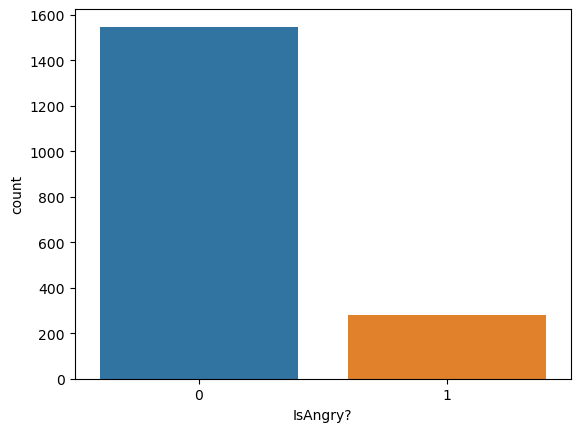

In [54]:
sns.countplot(data=df_train,x="IsAngry?")

Let's try to unbalance more the IsAngry? feature to 95% -> class 0 and 5% -> class 1 for train and test set

In [55]:
df_copy_train=df_train.copy()

indexNames=df_train[df_train["IsAngry?"]==1].sample(frac=0.70).index
df_copy_train.drop(indexNames,axis=0,inplace=True)

In [56]:
df_copy_train["IsAngry?"].value_counts(normalize=True)

0    0.948529
1    0.051471
Name: IsAngry?, dtype: float64

In [57]:
df_copy_train["IsAngry?"].value_counts()

0    1548
1      84
Name: IsAngry?, dtype: int64

<AxesSubplot:xlabel='IsAngry?', ylabel='count'>

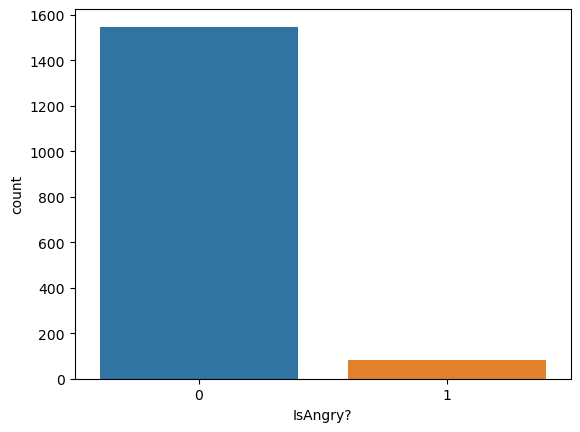

In [58]:
sns.countplot(data=df_copy_train,x="IsAngry?")

In [59]:
#Let's do the same unbalancing also for the test set
df_copy_test=df_test.copy()
indexNames=df_test[df_test["IsAngry?"]==1].sample(frac=0.70).index
df_copy_test.drop(indexNames,axis=0,inplace=True)
df_copy_test["IsAngry?"].value_counts(normalize=True)

0    0.947935
1    0.052065
Name: IsAngry?, dtype: float64

In [60]:
df_copy_test["IsAngry?"].value_counts()

0    528
1     29
Name: IsAngry?, dtype: int64

In [61]:
#Let's define the new set of train and test

col=[x for x in df_copy_train.columns if x!="IsAngry?"]
X_train_unb=df_copy_train[col].values
y_train_unb = np.array(df_copy_train["IsAngry?"])

X_test_unb=df_copy_test[col].values
y_test_unb = np.array(df_copy_test["IsAngry?"])

Let's build two models based on DT and KNN in this very unbalanced case

DT

In [38]:
param_grid = {'max_depth': [None, 2, 5, 10, 15, 20],
              'min_samples_split': [2, 5, 10, 15, 20],
              'min_samples_leaf': [1, 5, 10, 15, 20]
}

grid = GridSearchCV(
    DecisionTreeClassifier(),
    param_grid=param_grid,
    cv=StratifiedKFold(), # with no parameters it is with 5 split and 10 repetitions
    refit=True,
    scoring="f1_macro"
)
grid.fit(X_train_unb, y_train_unb)
clf = grid.best_estimator_
print(grid.best_params_)

{'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 15}


              precision    recall  f1-score   support

           0       0.97      0.98      0.97       528
           1       0.50      0.38      0.43        29

    accuracy                           0.95       557
   macro avg       0.73      0.68      0.70       557
weighted avg       0.94      0.95      0.94       557



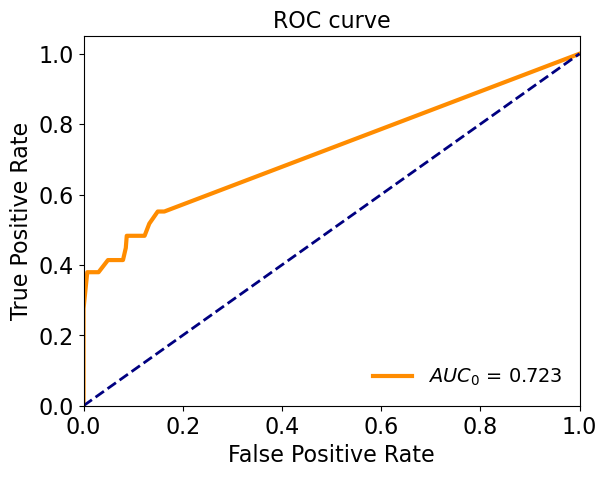

In [66]:
learner = DecisionTreeClassifier(max_depth=10,min_samples_split=15,min_samples_leaf=10)
classifier = learner.fit(X_train_unb, y_train_unb)
predictions = classifier.predict(X_test_unb)

print(classification_report(y_test_unb,predictions))

y_score = classifier.predict_proba(X_test_unb)
fpr0, tpr0, thr = roc_curve(y_test_unb, y_score[:,1])
roc_auc0 = auc(fpr0, tpr0)
plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

KNN

In [40]:
param_grid = {
    "n_neighbors": np.arange(2,51),
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "cityblock","minkowski"], # cityblock is the manhattan distance
}

grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid=param_grid,
    cv=StratifiedKFold(), # with no parameters it is with 5 split and 10 repetitions
    refit=True,
    scoring="f1_macro"
)

grid.fit(X_train_unb, y_train_unb)
clf = grid.best_estimator_
print(grid.best_params_)

{'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'}


In [41]:
learner = KNeighborsClassifier(n_neighbors= 2, metric= 'euclidean', weights= 'distance')
classifier = learner.fit(X_train_unb, y_train_unb)
predictions = classifier.predict(X_test_unb)

print(classification_report(y_test_unb,predictions))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       528
           1       0.29      0.24      0.26        29

    accuracy                           0.93       557
   macro avg       0.63      0.60      0.61       557
weighted avg       0.92      0.93      0.93       557



PCA to see the unbalanced data in 2 dimensions

In [26]:
from sklearn.decomposition import PCA
print(X_train_unb.shape)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_unb)
X_pca.shape

(1632, 258)


(1632, 2)

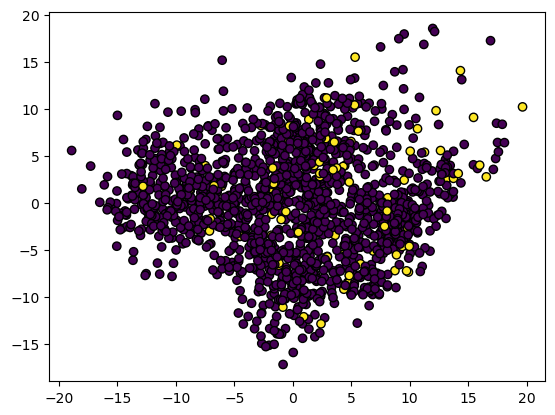

In [27]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train_unb,edgecolors='k')
plt.show()

# Undersampling

In [30]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.cluster import MiniBatchKMeans
from imblearn.under_sampling import ClusterCentroids
import warnings
warnings.simplefilter("ignore")
from collections import Counter

Let's see how the space in 2 dimensions with PCA change among different methods of Undersampling

Resampled dataset shape Counter({0: 84, 1: 84})
Resampled dataset shape Counter({0: 261, 1: 84})
Resampled dataset shape Counter({0: 261, 1: 84})
Resampled dataset shape Counter({0: 1416, 1: 84})


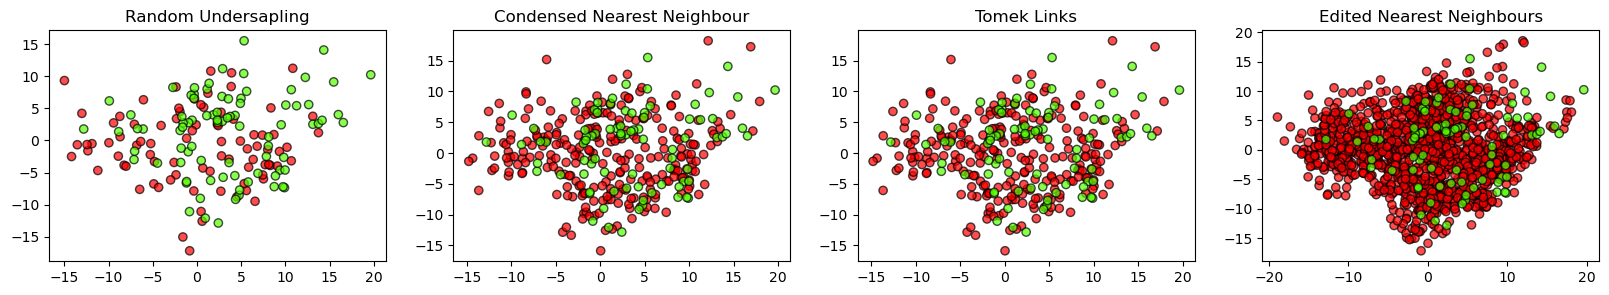

In [35]:
fig, axes = plt.subplots(1, 4, figsize=(20,3))

rus = RandomUnderSampler(random_state=42,sampling_strategy='majority')
X_res, y_res = rus.fit_resample(X_train_unb, y_train_unb)
print('Resampled dataset shape %s' % Counter(y_res))
pca = PCA(n_components=2)
pca.fit(X_train_unb)
X_pca = pca.transform(X_res)
axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
axes[0].set_title("Random Undersapling")

cnn = CondensedNearestNeighbour(random_state=42, n_jobs=10)
X_res, y_res = cnn.fit_resample(X_train_unb, y_train_unb)
print('Resampled dataset shape %s' % Counter(y_res))
pca = PCA(n_components=2)
pca.fit(X_train_unb)
X_pca = pca.transform(X_res)
axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
axes[1].set_title("Condensed Nearest Neighbour")

tl = TomekLinks(sampling_strategy='majority')
X_res, y_res = cnn.fit_resample(X_train_unb, y_train_unb)
print('Resampled dataset shape %s' % Counter(y_res))
pca = PCA(n_components=2)
pca.fit(X_train_unb)
X_pca = pca.transform(X_res)
axes[2].scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
axes[2].set_title("Tomek Links")

enn = EditedNearestNeighbours()
X_res, y_res = enn.fit_resample(X_train_unb, y_train_unb)
print('Resampled dataset shape %s' % Counter(y_res))
pca = PCA(n_components=2)
pca.fit(X_train_unb) 
X_pca = pca.transform(X_res) 
axes[3].scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
axes[3].set_title("Edited Nearest Neighbours")

plt.show()

Resampled dataset shape Counter({0: 84, 1: 84})


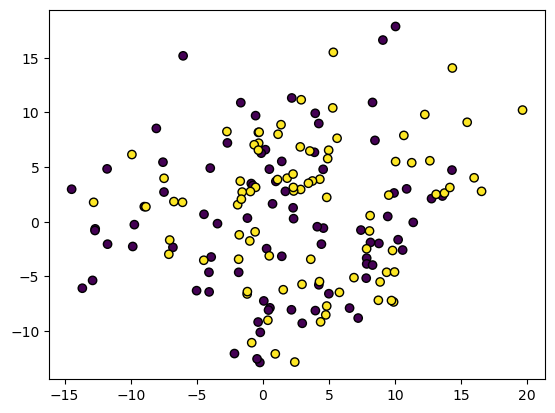

In [36]:

cc = ClusterCentroids(estimator=MiniBatchKMeans(n_init=1, random_state=0), random_state=42) # minibatch version is faster than Kmeans
X_res, y_res = cc.fit_resample(X_train_unb, y_train_unb)
print('Resampled dataset shape %s' % Counter(y_res))
pca = PCA(n_components=2)
pca.fit(X_train_unb) 
X_pca = pca.transform(X_res) 
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res,edgecolor='k')
plt.show()

Now let's test two models based on DT and KNN fitted on the Undersampled space

Random Undersampling

In [67]:
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train_unb, y_train_unb)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 84, 1: 84})


              precision    recall  f1-score   support

           0       0.96      0.69      0.80       528
           1       0.08      0.52      0.14        29

    accuracy                           0.68       557
   macro avg       0.52      0.60      0.47       557
weighted avg       0.92      0.68      0.77       557



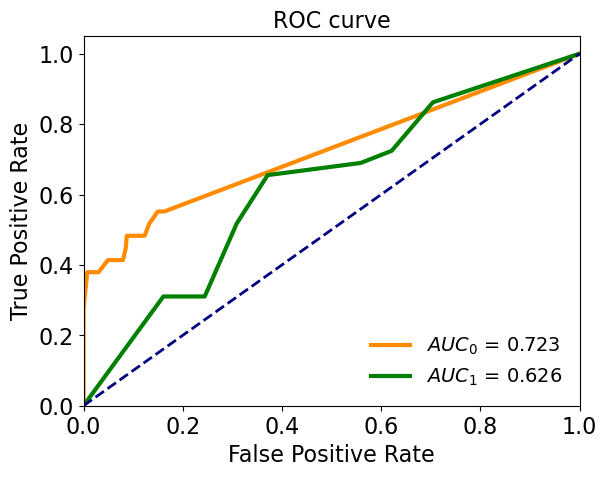

In [75]:
clf = DecisionTreeClassifier(max_depth=10,min_samples_split=15,min_samples_leaf=10)
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test_unb)
print(classification_report(y_test_unb, y_pred))

y_score = clf.predict_proba(X_test_unb)
fpr, tpr, _ = roc_curve(y_test_unb, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [77]:
learner = KNeighborsClassifier(n_neighbors= 2, metric= 'euclidean', weights= 'distance')
learner.fit(X_res, y_res)
y_pred = learner.predict(X_test_unb)
print(classification_report(y_test_unb,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.65      0.78       528
           1       0.10      0.69      0.17        29

    accuracy                           0.65       557
   macro avg       0.54      0.67      0.47       557
weighted avg       0.93      0.65      0.75       557



Condensed Nearest Neighbours

In [78]:
cnn = CondensedNearestNeighbour(random_state=42)
X_res, y_res = cnn.fit_resample(X_train_unb, y_train_unb)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 231, 1: 84})


              precision    recall  f1-score   support

           0       0.98      0.86      0.92       528
           1       0.20      0.62      0.30        29

    accuracy                           0.85       557
   macro avg       0.59      0.74      0.61       557
weighted avg       0.94      0.85      0.88       557



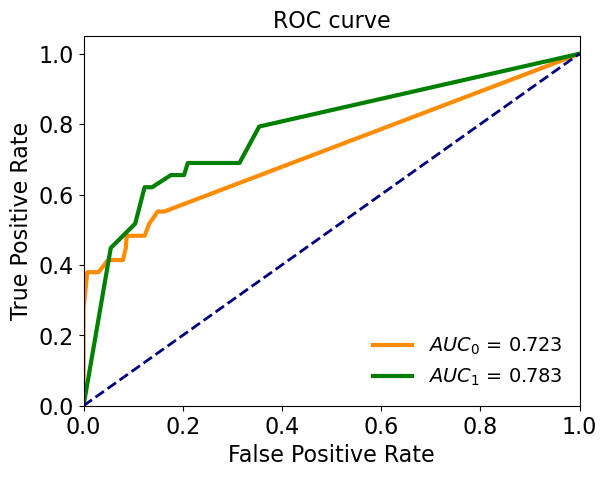

In [79]:
clf = DecisionTreeClassifier(max_depth=10,min_samples_split=15,min_samples_leaf=10)
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test_unb)
print(classification_report(y_test_unb, y_pred))

y_score = clf.predict_proba(X_test_unb)
fpr, tpr, _ = roc_curve(y_test_unb, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [80]:
learner = KNeighborsClassifier(n_neighbors= 2, metric= 'euclidean', weights= 'distance')
learner.fit(X_res, y_res)
y_pred = learner.predict(X_test_unb)
print(classification_report(y_test_unb,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.90      0.94       528
           1       0.24      0.55      0.33        29

    accuracy                           0.88       557
   macro avg       0.60      0.73      0.63       557
weighted avg       0.93      0.88      0.90       557



Tomek Links

In [88]:
tl = TomekLinks()
X_res, y_res = tl.fit_resample(X_train_unb, y_train_unb)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 1538, 1: 84})


              precision    recall  f1-score   support

           0       0.97      0.98      0.97       528
           1       0.50      0.38      0.43        29

    accuracy                           0.95       557
   macro avg       0.73      0.68      0.70       557
weighted avg       0.94      0.95      0.94       557



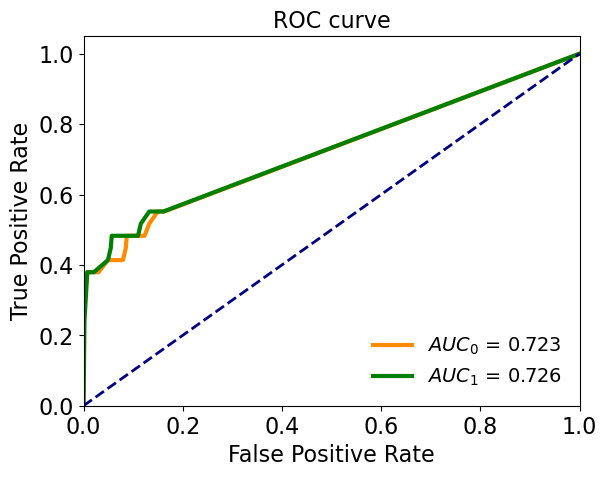

In [89]:
clf = DecisionTreeClassifier(max_depth=10,min_samples_split=15,min_samples_leaf=10)
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test_unb)
print(classification_report(y_test_unb, y_pred))

y_score = clf.predict_proba(X_test_unb)
fpr, tpr, _ = roc_curve(y_test_unb, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [90]:
learner = KNeighborsClassifier(n_neighbors= 2, metric= 'euclidean', weights= 'distance')
learner.fit(X_res, y_res)
y_pred = learner.predict(X_test_unb)
print(classification_report(y_test_unb,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       528
           1       0.24      0.31      0.27        29

    accuracy                           0.91       557
   macro avg       0.60      0.63      0.61       557
weighted avg       0.92      0.91      0.92       557



Edited Nearest Neighbours

In [91]:
enn = EditedNearestNeighbours()
X_res, y_res = enn.fit_resample(X_train_unb, y_train_unb)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 1443, 1: 84})


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       528
           1       0.67      0.48      0.56        29

    accuracy                           0.96       557
   macro avg       0.82      0.73      0.77       557
weighted avg       0.96      0.96      0.96       557



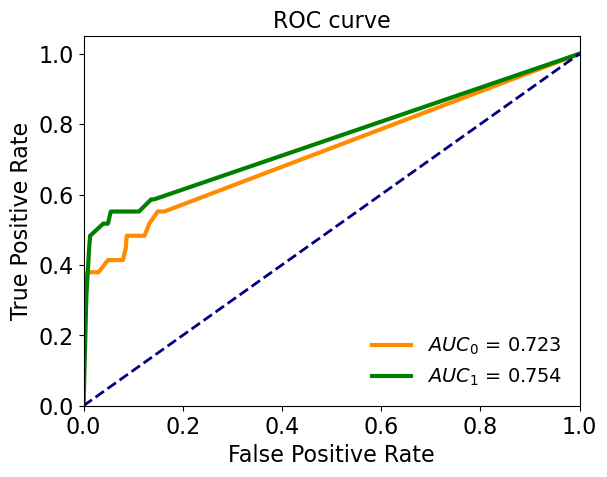

In [92]:
clf = DecisionTreeClassifier(max_depth=10,min_samples_split=15,min_samples_leaf=10)
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test_unb)
print(classification_report(y_test_unb, y_pred))

y_score = clf.predict_proba(X_test_unb)
fpr, tpr, _ = roc_curve(y_test_unb, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [93]:
learner = KNeighborsClassifier(n_neighbors= 2, metric= 'euclidean', weights= 'distance')
learner.fit(X_res, y_res)
y_pred = learner.predict(X_test_unb)
print(classification_report(y_test_unb,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.93      0.95       528
           1       0.22      0.34      0.27        29

    accuracy                           0.90       557
   macro avg       0.59      0.64      0.61       557
weighted avg       0.92      0.90      0.91       557



Cluster Centroids

In [94]:
cc = ClusterCentroids(estimator=MiniBatchKMeans(n_init=1, random_state=0), random_state=42) # minibatch version is faster than Kmeans
X_res, y_res = cc.fit_resample(X_train_unb, y_train_unb)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 84, 1: 84})


              precision    recall  f1-score   support

           0       0.98      0.57      0.72       528
           1       0.09      0.76      0.16        29

    accuracy                           0.58       557
   macro avg       0.53      0.67      0.44       557
weighted avg       0.93      0.58      0.69       557



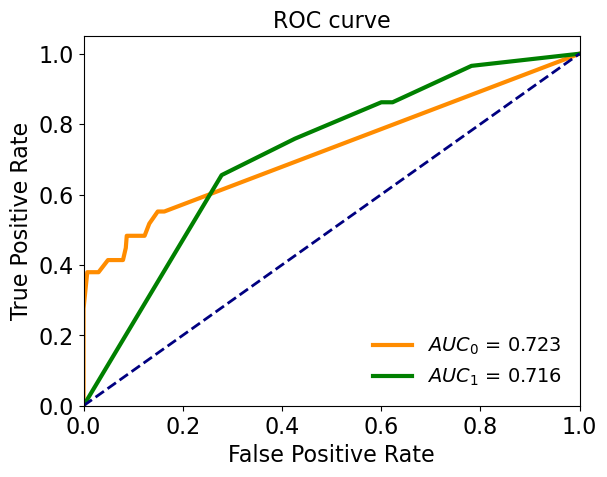

In [95]:
clf = DecisionTreeClassifier(max_depth=10,min_samples_split=15,min_samples_leaf=10)
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test_unb)
print(classification_report(y_test_unb, y_pred))

y_score = clf.predict_proba(X_test_unb)
fpr, tpr, _ = roc_curve(y_test_unb, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [96]:
learner = KNeighborsClassifier(n_neighbors= 2, metric= 'euclidean', weights= 'distance')
learner.fit(X_res, y_res)
y_pred = learner.predict(X_test_unb)
print(classification_report(y_test_unb,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       528
           1       0.24      0.38      0.30        29

    accuracy                           0.91       557
   macro avg       0.60      0.66      0.62       557
weighted avg       0.93      0.91      0.92       557



# Oversampling

In [98]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

Let's see how the space in 2 dimensions with PCA change among different methods of Oversampling

Resampled dataset shape Counter({0: 1548, 1: 1548})
Resampled dataset shape Counter({0: 1548, 1: 1548})
Resampled dataset shape Counter({1: 1567, 0: 1548})


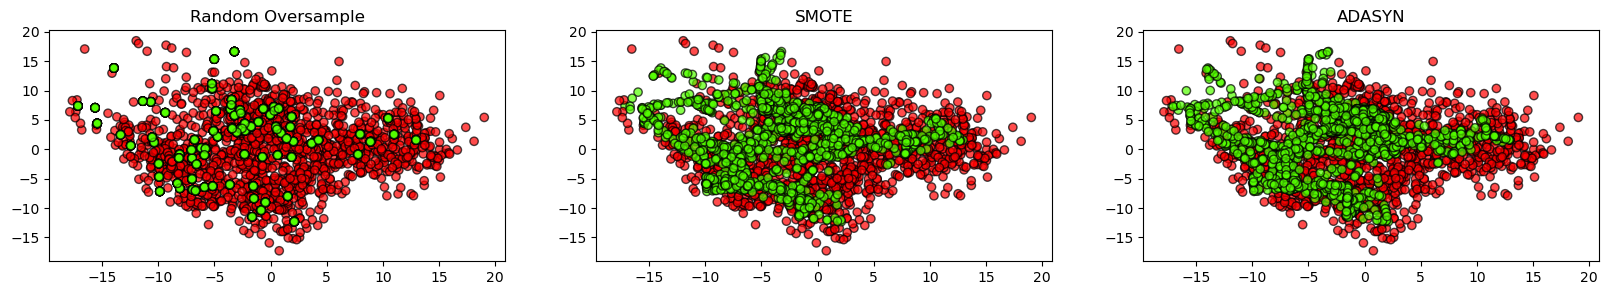

In [99]:
fig, axes = plt.subplots(1, 3, figsize=(20,3))

ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train_unb, y_train_unb)
print('Resampled dataset shape %s' % Counter(y_res))
pca = PCA(n_components=2)
pca.fit(X_train_unb)
X_pca = pca.transform(X_res)
axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
axes[0].set_title('Random Oversample')

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_unb, y_train_unb)
print('Resampled dataset shape %s' % Counter(y_res))
pca = PCA(n_components=2)
pca.fit(X_train_unb)
X_pca = pca.transform(X_res)
axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
axes[1].set_title('SMOTE')

adasyn  = ADASYN(random_state=42)
X_res, y_res = adasyn.fit_resample(X_train_unb, y_train_unb)
print('Resampled dataset shape %s' % Counter(y_res))
pca = PCA(n_components=2)
pca.fit(X_train_unb)
X_pca = pca.transform(X_res)
axes[2].scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
axes[2].set_title('ADASYN')

plt.show()

Now let's test two models based on DT and KNN fitted on the Undersampled space

Random Oversampling

In [100]:
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train_unb, y_train_unb)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 1548, 1: 1548})


              precision    recall  f1-score   support

           0       0.97      0.82      0.89       528
           1       0.15      0.59      0.24        29

    accuracy                           0.80       557
   macro avg       0.56      0.70      0.56       557
weighted avg       0.93      0.80      0.85       557



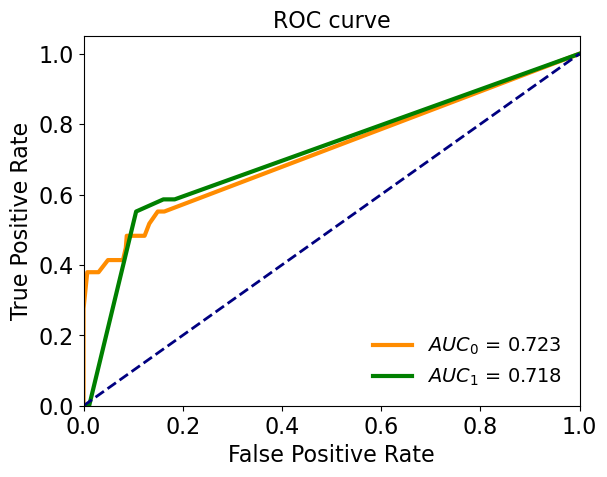

In [101]:
clf = DecisionTreeClassifier(max_depth=10,min_samples_split=15,min_samples_leaf=10)
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test_unb)
print(classification_report(y_test_unb, y_pred))

y_score = clf.predict_proba(X_test_unb)
fpr, tpr, _ = roc_curve(y_test_unb, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [102]:
learner = KNeighborsClassifier(n_neighbors= 2, metric= 'euclidean', weights= 'distance')
learner.fit(X_res, y_res)
y_pred = learner.predict(X_test_unb)
print(classification_report(y_test_unb,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       528
           1       0.25      0.31      0.28        29

    accuracy                           0.92       557
   macro avg       0.61      0.63      0.62       557
weighted avg       0.92      0.92      0.92       557



Smote

In [103]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_unb, y_train_unb)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 1548, 1: 1548})


              precision    recall  f1-score   support

           0       0.97      0.90      0.94       528
           1       0.22      0.52      0.31        29

    accuracy                           0.88       557
   macro avg       0.60      0.71      0.62       557
weighted avg       0.93      0.88      0.90       557



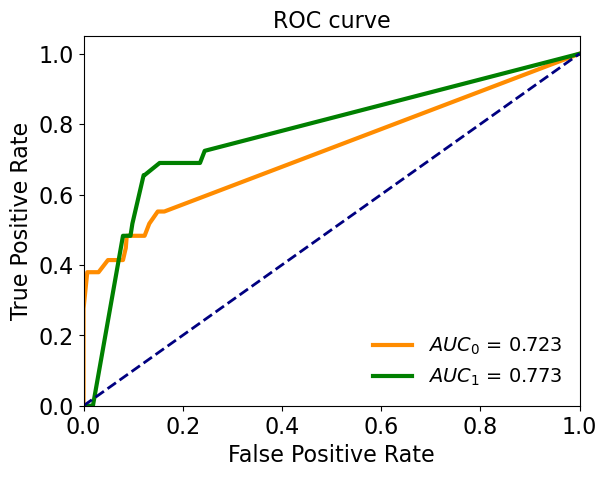

In [104]:
clf = DecisionTreeClassifier(max_depth=10,min_samples_split=15,min_samples_leaf=10)
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test_unb)
print(classification_report(y_test_unb, y_pred))

y_score = clf.predict_proba(X_test_unb)
fpr, tpr, _ = roc_curve(y_test_unb, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [105]:
learner = KNeighborsClassifier(n_neighbors= 2, metric= 'euclidean', weights= 'distance')
learner.fit(X_res, y_res)
y_pred = learner.predict(X_test_unb)
print(classification_report(y_test_unb,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.82      0.89       528
           1       0.17      0.69      0.27        29

    accuracy                           0.81       557
   macro avg       0.58      0.75      0.58       557
weighted avg       0.94      0.81      0.86       557



Adasyn

In [106]:
adasyn  = ADASYN(random_state=42)
X_res, y_res = adasyn.fit_resample(X_train_unb, y_train_unb)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({1: 1567, 0: 1548})


              precision    recall  f1-score   support

           0       0.97      0.88      0.92       528
           1       0.20      0.55      0.29        29

    accuracy                           0.86       557
   macro avg       0.59      0.72      0.61       557
weighted avg       0.93      0.86      0.89       557



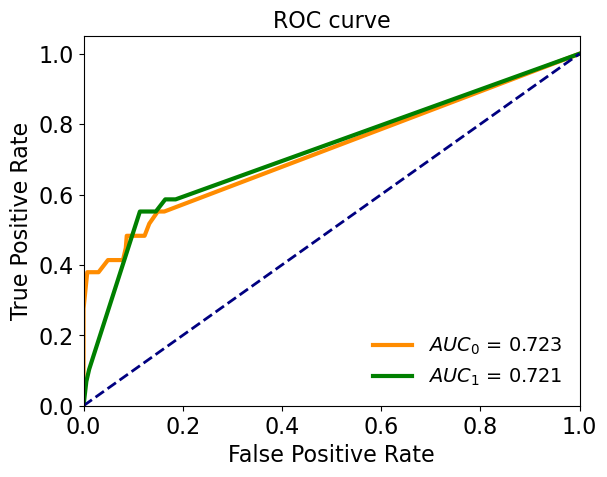

In [107]:
clf = DecisionTreeClassifier(max_depth=10,min_samples_split=15,min_samples_leaf=10)
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test_unb)
print(classification_report(y_test_unb, y_pred))

y_score = clf.predict_proba(X_test_unb)
fpr, tpr, _ = roc_curve(y_test_unb, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [108]:
learner = KNeighborsClassifier(n_neighbors= 2, metric= 'euclidean', weights= 'distance')
learner.fit(X_res, y_res)
y_pred = learner.predict(X_test_unb)
print(classification_report(y_test_unb,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.81      0.89       528
           1       0.17      0.69      0.27        29

    accuracy                           0.81       557
   macro avg       0.57      0.75      0.58       557
weighted avg       0.94      0.81      0.86       557



# Algoritmic Sampling

Class Weight

              precision    recall  f1-score   support

           0       0.98      0.91      0.94       528
           1       0.27      0.59      0.37        29

    accuracy                           0.89       557
   macro avg       0.62      0.75      0.65       557
weighted avg       0.94      0.89      0.91       557



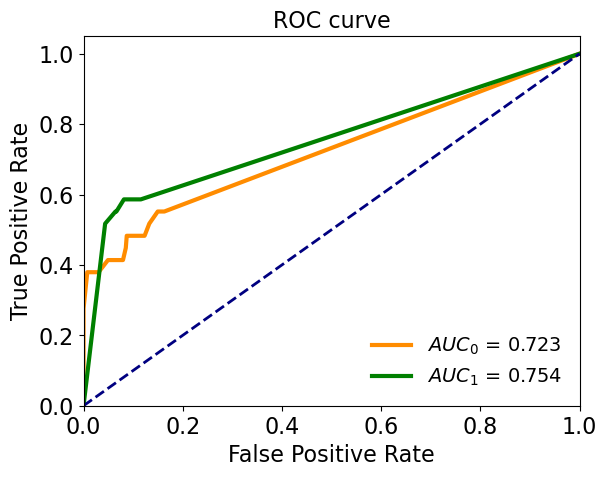

In [118]:
clf = DecisionTreeClassifier(max_depth=10,min_samples_split=15,min_samples_leaf=10,class_weight={0:1, 1: 5}, random_state=42)
clf.fit(X_train_unb, y_train_unb)

y_pred = clf.predict(X_test_unb)

print(classification_report(y_test_unb, y_pred))

y_score = clf.predict_proba(X_test_unb)
fpr, tpr, _ = roc_curve(y_test_unb, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

Meta-Cost Sensitive Classifier

In [121]:
import sys
import joblib
import six
import sklearn.ensemble._base
sys.modules['sklearn.externals.joblib'] = joblib
sys.modules['sklearn.externals.six'] = six
sys.modules['sklearn.externals.six.moves'] = six.moves
sys.modules['sklearn.ensemble.base'] = sklearn.ensemble._base

!pip install costcla
from costcla.models import CostSensitiveDecisionTreeClassifier
from costcla.metrics import savings_score

  Created wheel for pyea: filename=pyea-0.2-py3-none-any.whl size=6018 sha256=18a8a2ab5c04b8e7e592b44fc941ccacf4019854a24fd28e932c75252c65d8c7
  Stored in directory: c:\users\david\appdata\local\pip\cache\wheels\e5\35\eb\1eaf44b8b95d4751bb25f06931913cf5809cd885f15e70ea71
Successfully built pyea


In [122]:
cost = [1, 10, 0, 0]  # if we want to apply this to all records we have to build a matrix of len(training)
cost_mat = np.array([cost] * len(X_train_unb))
cost_mat.shape

(1632, 4)

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       528
           1       0.46      0.55      0.50        29

    accuracy                           0.94       557
   macro avg       0.72      0.76      0.73       557
weighted avg       0.95      0.94      0.95       557



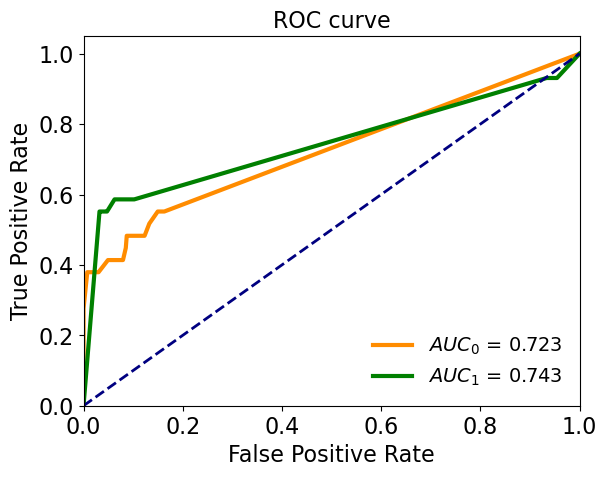

In [123]:
clf = CostSensitiveDecisionTreeClassifier()
clf.fit(X_train_unb, y_train_unb, cost_mat)

y_pred = clf.predict(X_test_unb)

print(classification_report(y_test_unb, y_pred))

y_score = clf.predict_proba(X_test_unb)
fpr, tpr, _ = roc_curve(y_test_unb, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

Now let's try to apply Dimensionality Reduction Technics to the  original sample space and not to the unbalanced

In [125]:
len(X_train), len(y_train), len(X_test), len(y_test)

(1828, 1828, 624, 624)

# Dimensionality reduction (Feature Selection)

Models performance without Dimensionality Reduction

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       528
           1       0.61      0.64      0.62        96

    accuracy                           0.88       624
   macro avg       0.77      0.78      0.78       624
weighted avg       0.88      0.88      0.88       624



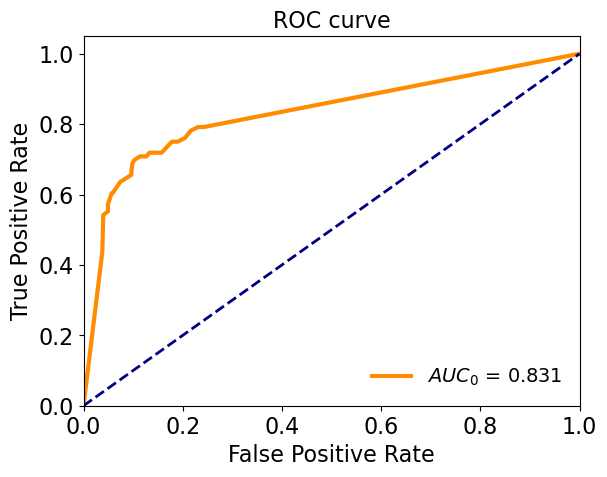

In [20]:
learner = DecisionTreeClassifier(max_depth=None,min_samples_split=2,min_samples_leaf=15)
classifier = learner.fit(X_train, y_train)
predictions = classifier.predict(X_test)
print(classification_report(y_test,predictions))

y_score = classifier.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [129]:
learner = KNeighborsClassifier(n_neighbors= 5, metric= 'euclidean', weights= 'uniform')
classifier = learner.fit(X_train, y_train)
predictions = classifier.predict(X_test)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       528
           1       0.69      0.51      0.59        96

    accuracy                           0.89       624
   macro avg       0.80      0.73      0.76       624
weighted avg       0.88      0.89      0.88       624



Variance Threshold

In [126]:
from sklearn.feature_selection import VarianceThreshold

In [132]:
#Let's test different Threshold for DT and KNN
thresholds = [0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.15, 0.16, 0.25, 1]
for i in thresholds:
    sel = VarianceThreshold(i)
    print(str(i))
    X_train_sel = sel.fit_transform(X_train)
    print(X_train_sel.shape)
    X_test_sel = sel.transform(X_test)

    learner=DecisionTreeClassifier(max_depth=None,min_samples_split=2,min_samples_leaf=15)
    learner.fit(X_train_sel, y_train)
    y_pred = learner.predict(X_test_sel)
    print('DT - Accuracy %s' % accuracy_score(y_test, y_pred))
    print('DT - F1 Score %s' % f1_score(y_test, y_pred,average="macro"))

    learner = KNeighborsClassifier(n_neighbors= 5, metric= 'euclidean', weights= 'uniform')
    learner.fit(X_train_sel, y_train)
    y_pred = learner.predict(X_test_sel)
    print('KNN - Accuracy %s' % accuracy_score(y_test, y_pred))
    print('KNN - F1 Score %s' % f1_score(y_test, y_pred,average="macro"))

0.02
(1828, 258)
DT - Accuracy 0.8814102564102564
DT - F1 Score 0.7760533871343214
KNN - Accuracy 0.8894230769230769
KNN - F1 Score 0.7614982800356733
0.04
(1828, 258)
DT - Accuracy 0.8814102564102564
DT - F1 Score 0.7760533871343214
KNN - Accuracy 0.8894230769230769
KNN - F1 Score 0.7614982800356733
0.06
(1828, 258)
DT - Accuracy 0.8814102564102564
DT - F1 Score 0.7760533871343214
KNN - Accuracy 0.8894230769230769
KNN - F1 Score 0.7614982800356733
0.08
(1828, 258)
DT - Accuracy 0.8814102564102564
DT - F1 Score 0.7760533871343214
KNN - Accuracy 0.8894230769230769
KNN - F1 Score 0.7614982800356733
0.1
(1828, 258)
DT - Accuracy 0.8814102564102564
DT - F1 Score 0.7760533871343214
KNN - Accuracy 0.8894230769230769
KNN - F1 Score 0.7614982800356733
0.12
(1828, 258)
DT - Accuracy 0.8814102564102564
DT - F1 Score 0.7760533871343214
KNN - Accuracy 0.8894230769230769
KNN - F1 Score 0.7614982800356733
0.15
(1828, 258)
DT - Accuracy 0.8814102564102564
DT - F1 Score 0.7760533871343214
KNN - Accura

Univariate Feature Selection

In [131]:
from sklearn.feature_selection import SelectKBest

In [133]:
#Let's test different Threshold for DT and KNN
for i in range(20, 60):
    sel = SelectKBest(k=i)
    print(str(i))
    X_train_sel = sel.fit_transform(X_train, y_train)
    print(X_train_sel.shape)
    X_test_sel = sel.transform(X_test)

    learner=DecisionTreeClassifier(max_depth=None,min_samples_split=2,min_samples_leaf=15)
    learner.fit(X_train_sel, y_train)
    y_pred = learner.predict(X_test_sel)
    print('DT - Accuracy %s' % accuracy_score(y_test, y_pred))
    print('DT - F1 Score %s' % f1_score(y_test, y_pred,average="macro"))

    learner = KNeighborsClassifier(n_neighbors= 5, metric= 'euclidean', weights= 'uniform')
    learner.fit(X_train_sel, y_train)
    y_pred = learner.predict(X_test_sel)
    print('KNN - Accuracy %s' % accuracy_score(y_test, y_pred))
    print('KNN - F1 Score %s' % f1_score(y_test, y_pred,average="macro"))

20
(1828, 20)
DT - Accuracy 0.8493589743589743
DT - F1 Score 0.6665984584953277
KNN - Accuracy 0.8846153846153846
KNN - F1 Score 0.7662921348314609
21
(1828, 21)
DT - Accuracy 0.8397435897435898
DT - F1 Score 0.6692672998643148
KNN - Accuracy 0.875
KNN - F1 Score 0.746816479400749
22
(1828, 22)
DT - Accuracy 0.8397435897435898
DT - F1 Score 0.656084656084656
KNN - Accuracy 0.8717948717948718
KNN - F1 Score 0.7403245942571786
23
(1828, 23)
DT - Accuracy 0.8397435897435898
DT - F1 Score 0.656084656084656
KNN - Accuracy 0.8766025641025641
KNN - F1 Score 0.7441192917054986
24
(1828, 24)
DT - Accuracy 0.8397435897435898
DT - F1 Score 0.656084656084656
KNN - Accuracy 0.8782051282051282
KNN - F1 Score 0.7462274449367494
25
(1828, 25)
DT - Accuracy 0.8621794871794872
DT - F1 Score 0.7182400504042844
KNN - Accuracy 0.8782051282051282
KNN - F1 Score 0.7510028352409954
26
(1828, 26)
DT - Accuracy 0.8637820512820513
DT - F1 Score 0.7302890849457171
KNN - Accuracy 0.875
KNN - F1 Score 0.74202849389

Select From Model

In [14]:
from sklearn.feature_selection import SelectFromModel

DT New dimension:(1828, 23)

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       528
           1       0.61      0.64      0.62        96

    accuracy                           0.88       624
   macro avg       0.77      0.78      0.78       624
weighted avg       0.88      0.88      0.88       624



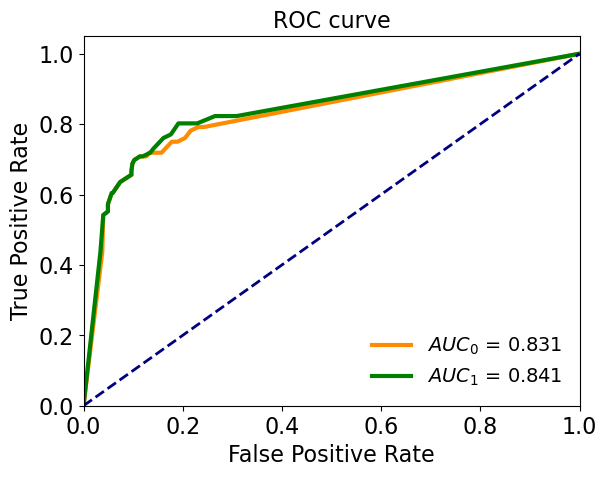

In [21]:
sel = SelectFromModel(DecisionTreeClassifier(max_depth=None,min_samples_split=2,min_samples_leaf=15))
X_train_sel = sel.fit_transform(X_train, y_train)
print(f"DT New dimension:{X_train_sel.shape}\n")

X_test_sel = sel.transform(X_test)
clf = DecisionTreeClassifier(max_depth=None,min_samples_split=2,min_samples_leaf=15)
clf.fit(X_train_sel, y_train)
y_pred = clf.predict(X_test_sel)
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test_sel)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [22]:
learner = KNeighborsClassifier(n_neighbors= 5, metric= 'euclidean', weights= 'uniform')
learner.fit(X_train_sel, y_train)
y_pred = learner.predict(X_test_sel)
print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

           0       0.92      0.96      0.94       528
           1       0.70      0.53      0.60        96

    accuracy                           0.89       624
   macro avg       0.81      0.74      0.77       624
weighted avg       0.88      0.89      0.89       624



Recursive Feature Elimination

In [23]:
from sklearn.feature_selection import RFE

In [24]:
#Let's test different k range for DT and KNN
for i in range(20, 60):
    print(str(i))

    sel = RFE(DecisionTreeClassifier(max_depth=None, min_samples_split=2, min_samples_leaf=15), n_features_to_select=i)
    X_train_sel = sel.fit_transform(X_train, y_train)
    print(f" DT New dimension: {X_train_sel.shape}")
    X_test_sel = sel.transform(X_test)

    learner= DecisionTreeClassifier(max_depth=10, min_samples_split=2, min_samples_leaf=20)
    learner.fit(X_train_sel, y_train)
    y_pred = learner.predict(X_test_sel)
    print('DT - Accuracy %s' % accuracy_score(y_test, y_pred))
    print('DT - F1 Score %s' % f1_score(y_test, y_pred,average="macro"))

    learner= KNeighborsClassifier(n_neighbors= 5, metric= 'euclidean', weights= 'uniform')
    learner.fit(X_train_sel, y_train)
    y_pred = learner.predict(X_test_sel)
    print('KNN - Accuracy %s' % accuracy_score(y_test, y_pred))
    print('KNN - F1 Score %s' % f1_score(y_test, y_pred,average="macro"))

20
 DT New dimension: (1828, 20)
DT - Accuracy 0.8814102564102564
DT - F1 Score 0.7741739861890882
KNN - Accuracy 0.907051282051282
KNN - F1 Score 0.8025100949470698
21
 DT New dimension: (1828, 21)
DT - Accuracy 0.8814102564102564
DT - F1 Score 0.7741739861890882
KNN - Accuracy 0.907051282051282
KNN - F1 Score 0.8025100949470698
22
 DT New dimension: (1828, 22)
DT - Accuracy 0.8814102564102564
DT - F1 Score 0.7741739861890882
KNN - Accuracy 0.8990384615384616
KNN - F1 Score 0.7822375600325713
23
 DT New dimension: (1828, 23)
DT - Accuracy 0.8814102564102564
DT - F1 Score 0.7741739861890882
KNN - Accuracy 0.8862179487179487
KNN - F1 Score 0.7662884362784662
24
 DT New dimension: (1828, 24)
DT - Accuracy 0.8814102564102564
DT - F1 Score 0.7741739861890882
KNN - Accuracy 0.9006410256410257
KNN - F1 Score 0.7867724867724868
25
 DT New dimension: (1828, 25)
DT - Accuracy 0.8814102564102564
DT - F1 Score 0.7741739861890882
KNN - Accuracy 0.8926282051282052
KNN - F1 Score 0.7707278819419691


Dimensionality Reduction (Feature Projection)

PCA

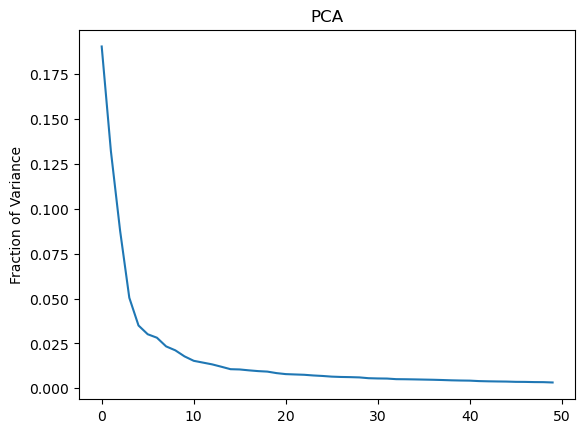

In [26]:
from sklearn.decomposition import PCA
plt.plot(PCA(n_components=50).fit(X_train,y_train).explained_variance_ratio_)
plt.title("PCA")
plt.ylabel("Fraction of Variance")
plt.show()

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       528
           1       0.64      0.57      0.60        96

    accuracy                           0.88       624
   macro avg       0.78      0.76      0.77       624
weighted avg       0.88      0.88      0.88       624



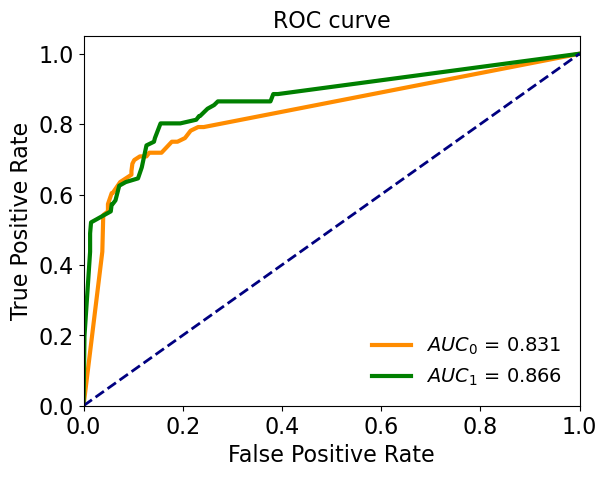

In [31]:
pca = PCA(n_components=10)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

clf = DecisionTreeClassifier(max_depth=None, min_samples_split=2, min_samples_leaf=15)
clf.fit(X_train_pca, y_train)
y_pred = clf.predict(X_test_pca)

print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test_pca)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()



In [28]:
clf = KNeighborsClassifier(n_neighbors= 5, metric= 'euclidean', weights= 'uniform')
clf.fit(X_train_pca, y_train)
y_pred = clf.predict(X_test_pca)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89       528
           1       0.32      0.23      0.27        96

    accuracy                           0.81       624
   macro avg       0.60      0.57      0.58       624
weighted avg       0.78      0.81      0.79       624



Random Subspace Projection

In [33]:
from sklearn import random_projection

rsp = random_projection.GaussianRandomProjection(n_components=10, random_state=0)
X_train_rsp = rsp.fit_transform(X_train)
X_train_rsp.shape

(1828, 10)

In [34]:
X_test_rsp = rsp.transform(X_test)
clf = DecisionTreeClassifier(max_depth=None, min_samples_split=2, min_samples_leaf=15)
clf.fit(X_train_rsp, y_train)
y_pred = clf.predict(X_test_rsp)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.92      0.90       528
           1       0.39      0.27      0.32        96

    accuracy                           0.82       624
   macro avg       0.63      0.60      0.61       624
weighted avg       0.80      0.82      0.81       624



In [35]:
clf = KNeighborsClassifier(n_neighbors= 5, metric= 'euclidean', weights= 'uniform')
clf.fit(X_train_rsp, y_train)
y_pred = clf.predict(X_test_rsp)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92       528
           1       0.57      0.25      0.35        96

    accuracy                           0.86       624
   macro avg       0.72      0.61      0.63       624
weighted avg       0.83      0.86      0.83       624



Multidimensional Scaling

In [36]:
from sklearn.manifold import MDS
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE

Let's see how the space in 2D changes among MDS, IsoMap, t-SNE

c:\Users\david\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\david\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


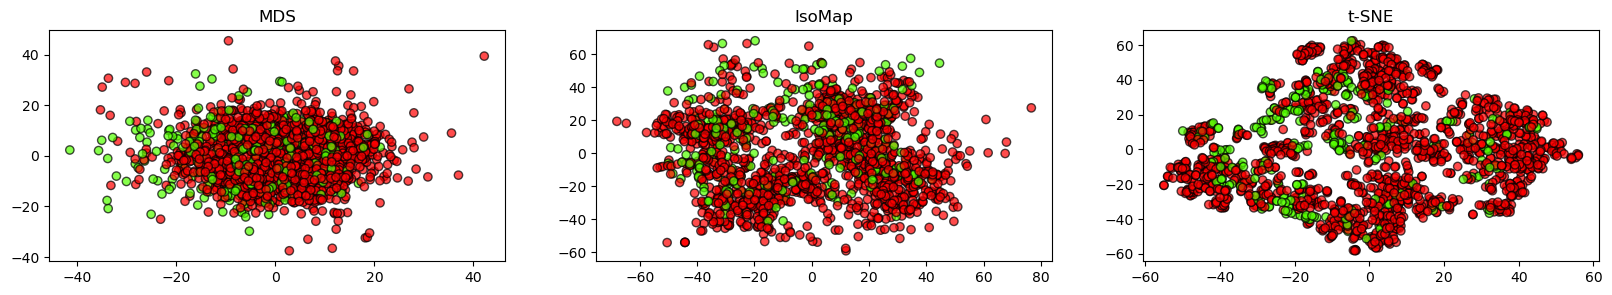

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(20,3))


mds = MDS(n_components=2) #, normalized_stress='auto') # shoudl run as sammon mapping
X_train_mds = mds.fit_transform(X_train)
X_train_mds.shape
axes[0].scatter(X_train_mds[:, 0], X_train_mds[:, 1], c=y_train, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
axes[0].set_title('MDS')

iso = Isomap(n_components=2)
X_train_iso = iso.fit_transform(X_train)
X_train_iso.shape
axes[1].scatter(X_train_iso[:, 0], X_train_iso[:, 1], c=y_train, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
axes[1].set_title('IsoMap')

tsne = TSNE(n_components=2)
X_train_tsne = tsne.fit_transform(X_train)
X_train_tsne.shape
axes[2].scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
axes[2].set_title('t-SNE')

plt.show()